# Profiling

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [1]:
# !pip install skforecast==0.15.1

In [2]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.utils import *

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.datasets import fetch_dataset

%load_ext pyinstrument
%load_ext line_profiler

# Information system and libraries

In [3]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.11.10
scikit-learn version: 1.6.1
skforecast version: 0.16.0
pandas version: 2.2.3
numpy version: 2.2.5
scipy version: 1.15.2
psutil version: 7.0.0

Computer network name: ITES015-NB0029
Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-10-10.0.19045-SP0
Operating system: Windows
Operating system release: 10
Operating system version: 10.0.19045
Number of physical cores: 8
Number of logical cores: 16


# ForecasterAutoregMultiSeries

In [4]:
n_series = 600
len_series = (2000, 5000)
series_dict = {}
rng = np.random.default_rng(321)
for i in range(n_series):
    #n = rng.integers(low=len_series[0], high=len_series[1])
    n=2000
    series_dict[f'series_{i}'] = pd.Series(
        data = rng.normal(loc=20, scale=5, size=n),
        index=pd.date_range(
            start='2010-01-01',
            periods=n,
            freq='h'
        ),
        name=f'series_{i}'
    )
series_dataframe = pd.DataFrame(series_dict, index=series_dict['series_0'].index)

exog_dict = {}
rng = np.random.default_rng(321)
for k in series_dict.keys():
    exog = pd.DataFrame(
            index=series_dict[k].index
            )
    exog['day_of_week'] = exog.index.dayofweek
    exog['week_of_year'] = exog.index.isocalendar().week.astype(int)
    exog['month'] = exog.index.month
    exog_dict[k] = exog


exog_dict_prediction = {}
for k in series_dict.keys():
    exog = pd.DataFrame(
            index=pd.date_range(
                start=series_dict[k].index.max() + pd.Timedelta(hours=1),
                periods=100,
                freq='h'
            )
            )
    exog['day_of_week'] = exog.index.dayofweek
    exog['week_of_year'] = exog.index.isocalendar().week.astype(int)
    exog['month'] = exog.index.month
    exog_dict_prediction[k] = exog   


print(f"Range of dates: "
    f"{np.min([series_dict[k].index.min() for k in series_dict.keys()])} - "
    f"{np.max([series_dict[k].index.max() for k in series_dict.keys()])}"
)

print(f"Range of dates for prediction: "
      f"{np.min([exog_dict_prediction[k].index.min() for k in exog_dict_prediction.keys()])} - "
    f"{np.max([exog_dict_prediction[k].index.max() for k in exog_dict_prediction.keys()])}"
)

Range of dates: 2010-01-01 00:00:00 - 2010-03-25 07:00:00
Range of dates for prediction: 2010-03-25 08:00:00 - 2010-03-29 11:00:00


In [18]:
# Forecaster
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=8520, verbose=-1),
    lags=50,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
    encoding="ordinal"
)

In [19]:
# Execute all with exog_dict as None
# ==============================================================================
exog_dict = None
exog_dict_prediction = None

In [20]:
# Profiling _create_train_X_y()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster._create_train_X_y(series=series, exog=exog)

%lprun -f forecaster._create_train_X_y funt_to_profile(forecaster, series_dataframe, exog_dict)

Timer unit: 1e-07 s

Total time: 3.62915 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: _create_train_X_y at line 962

Line #      Hits         Time  Per Hit   % Time  Line Contents
   962                                               def _create_train_X_y(
   963                                                   self,
   964                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   965                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
   966                                                   store_last_window: bool | list[str] = True,
   967                                               ) -> tuple[
   968                                                   pd.DataFrame,
   969                                                   pd.Series,
   970                                               

In [7]:
%%timeit -r 5

forecaster.fit(series=series_dataframe)

7.09 s ± 215 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


+ 0.14.0
    + 17.7 s ± 805 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

+ 0.15.0
    + 17.1 s ± 392 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
    + 11.6 s ± 491 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

+ 0.16.0
    + 17.2 s ± 391 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
    + 11.9 s ± 622 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

_     ._   __/__   _ _  _  _ _/_   Recorded: 13:44:57  Samples:  3529
 /_//_/// /_\ / //_// / //_'/ //     Duration: 8.245     CPU time: 33.750
/   _/                      v5.0.0

Cell [21]

8.246 <module>  ..\..\AppData\Local\Temp\ipykernel_34256\2556795436.py:1
`- 8.244 ForecasterRecursiveMultiSeries.fit  skforecast\recursive\_forecaster_recursive_multiseries.py:1638
   |- 3.528 LGBMRegressor.fit  lightgbm\sklearn.py:1172
   |     [14 frames hidden]  lightgbm, <built-in>, pandas
   |        2.379 Booster.update  lightgbm\basic.py:4073
   |- 2.520 ForecasterRecursiveMultiSeries._create_train_X_y  skforecast\recursive\_forecaster_recursive_multiseries.py:962
   |  |- 1.827 ForecasterRecursiveMultiSeries._create_train_X_y_single_series  skforecast\recursive\_forecaster_recursive_multiseries.py:837
   |  |  |- 1.314 transform_series  skforecast\utils\utils.py:1952
   |  |  |  |- 0.679 StandardScaler.fit  sklearn\preprocessing\_data.py:869
   |  |  |  |     [10 frames hidden]  sklearn, pandas
   |  |  |  `- 0.567 StandardScaler.wrapped  sklearn\utils\_set_output.py:317
   |  |  |        [5 frames hidden]  sklearn, pandas
   |  |  |- 0.295 ForecasterRecursiveMultiSeries._create_lags  skforecast\recursive\_forecaster_recursive_multiseries.py:725
   |  |  |  |- 0.165 full  numpy\_core\numeric.py:290
   |  |  |  `- 0.087 DataFrame.__init__  pandas\core\frame.py:694
   |  |  `- 0.161 DataFrame.__setitem__  pandas\core\frame.py:4271
   |  |        [3 frames hidden]  pandas
   |  |- 0.176 concat  pandas\core\reshape\concat.py:157
   |  |     [2 frames hidden]  pandas
   |  |- 0.148 OrdinalEncoder.wrapped  sklearn\utils\_set_output.py:317
   |  |     [6 frames hidden]  sklearn
   |  `- 0.138 <dictcomp>  skforecast\recursive\_forecaster_recursive_multiseries.py:1261
   |     `- 0.123 _iLocIndexer.__getitem__  pandas\core\indexing.py:1176
   |           [6 frames hidden]  pandas
   |- 0.736 Series.__getitem__  pandas\core\series.py:1095
   |     [5 frames hidden]  pandas
   |- 0.649 [self]  skforecast\recursive\_forecaster_recursive_multiseries.py
   |- 0.610 LGBMRegressor.predict  lightgbm\sklearn.py:992
   |     [6 frames hidden]  lightgbm, <built-in>
   `- 0.125 <dictcomp>  skforecast\recursive\_forecaster_recursive_multiseries.py:1765
      `- 0.124 DatetimeIndex.__getitem__  pandas\core\indexes\base.py:5373
         `- 0.116 DatetimeArray.__getitem__  pandas\core\arrays\datetimelike.py:373
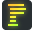

In [21]:
%%pyinstrument
forecaster.fit(series=series_dataframe, exog=exog_dict)

In [22]:
# Profiling fit()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster.fit(series=series, exog=exog)

%lprun -f forecaster.fit funt_to_profile(forecaster, series_dataframe, exog_dict)

Timer unit: 1e-07 s

Total time: 9.71047 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: fit at line 1638

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1638                                               def fit(
  1639                                                   self,
  1640                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
  1641                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  1642                                                   store_last_window: bool | list[str] = True,
  1643                                                   store_in_sample_residuals: bool = False,
  1644                                                   random_state: int = 123,
  1645                                                   suppress_warnings: bool = False
  1646         

In [24]:
# Profiling _create_train_X_y_single_series()
# ==============================================================================
forecaster.fit(series=series_dataframe, exog=exog_dict)
def funt_to_profile(forecaster, series, exog):
    (
    X_train_autoreg,
    X_train_window_features_names_out_,
    X_train_exog,
    y_train
) = forecaster._create_train_X_y_single_series(
        y = series,
        exog = exog,
        ignore_exog = False,
    )

serie = series_dataframe['series_0']
%lprun -f forecaster._create_train_X_y_single_series funt_to_profile(forecaster, serie, exog_dict)

Timer unit: 1e-07 s

Total time: 0.0034238 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: _create_train_X_y_single_series at line 837

Line #      Hits         Time  Per Hit   % Time  Line Contents
   837                                               def _create_train_X_y_single_series(
   838                                                   self,
   839                                                   y: pd.Series,
   840                                                   ignore_exog: bool,
   841                                                   exog: pd.DataFrame | None = None
   842                                               ) -> tuple[pd.DataFrame, list[str], pd.DataFrame, pd.Series]:
   843                                                   """
   844                                                   Create training matrices from univariate time series and exogenous
   845                                           

In [26]:
# Profiling transform_series()
# ==============================================================================
from skforecast.utils import transform_series
forecaster.fit(series=series_dataframe, exog=exog_dict)

def funt_to_profile(y, transformer):
    transform_series(series=y, transformer=transformer, fit=True, inverse_transform=False)

serie = series_dataframe['series_0']
transformer = forecaster.transformer_series_['series_0']
%lprun -f transform_series funt_to_profile(serie, transformer)

Timer unit: 1e-07 s

Total time: 0.003891 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py
Function: transform_series at line 1952

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1952                                           def transform_series(
  1953                                               series: pd.Series,
  1954                                               transformer: object | None,
  1955                                               fit: bool = False,
  1956                                               inverse_transform: bool = False
  1957                                           ) -> pd.Series | pd.DataFrame:
  1958                                               """
  1959                                               Transform raw values of pandas Series with a scikit-learn alike 
  1960                                               transformer, preprocessor or ColumnTransformer. The transformer used must 
  1961                

In [ ]:
# Profiling predict()
# ==============================================================================
forecaster.fit(series=series_dataframe, exog=exog_dict)

def funt_to_profile(forecaster, steps, exog):
    forecaster.predict(steps=steps, exog=exog, suppress_warnings=True)

%lprun -f forecaster.predict funt_to_profile(forecaster, 100, exog_dict_prediction)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: Future

Timer unit: 1e-07 s

Total time: 1.09465 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: predict at line 2595

Line #      Hits         Time  Per Hit   % Time  Line Contents
  2595                                               def predict(
  2596                                                   self,
  2597                                                   steps: int,
  2598                                                   levels: str | list[str] | None = None,
  2599                                                   last_window: pd.DataFrame | None = None,
  2600                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  2601                                                   suppress_warnings: bool = False,
  2602                                                   check_inputs: bool = True
  2603                                               ) -> 

In [12]:
# Profiling predict_new
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    forecaster.predict_new(steps=steps, exog=exog, suppress_warnings=True)

%lprun -f forecaster.predict_new funt_to_profile(forecaster, 100, exog_dict_prediction)

UsageError: Could not find module forecaster.predict_new.
AttributeError: 'ForecasterRecursiveMultiSeries' object has no attribute 'predict_new'


In [ ]:
%%timeit
forecaster.predict(steps=100, exog=exog_dict_prediction, suppress_warnings=True)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: Future

1.21 s ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
forecaster.predict_new(steps=100, exog=exog_dict_prediction, suppress_warnings=True)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: Future

450 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: Future

In [ ]:
old = forecaster.predict(steps = 100, exog=exog_dict_prediction)
new = forecaster.predict_new(steps = 100, exog=exog_dict_prediction)
pd.testing.assert_frame_equal(old, new)

In [13]:
# Profiling _create_predict_inputs()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    (
        last_window,
        exog_values_dict,
        levels,
        prediction_index
    ) = forecaster._create_predict_inputs(
        steps         = steps,
        #levels       = forecaster.levels,
        #last_window  = forecaster.last_window_,
        exog         = exog_dict_prediction,
        check_inputs = True
    )

%lprun -f forecaster._create_predict_inputs funt_to_profile(forecaster, 100, exog_dict_prediction)

Timer unit: 1e-07 s

Total time: 0.66522 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: _create_predict_inputs at line 2102

Line #      Hits         Time  Per Hit   % Time  Line Contents
  2102                                               def _create_predict_inputs(
  2103                                                   self,
  2104                                                   steps: int,
  2105                                                   levels: str | list[str] | None = None,
  2106                                                   last_window: pd.DataFrame | None = None,
  2107                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  2108                                                   predict_probabilistic: bool = False,
  2109                                                   use_in_sample_residuals: bool = True,
  2110      

In [14]:
# Profiling _create_predict_inputs()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    (
        last_window,
        exog_values_dict,
        levels,
        prediction_index
    ) = forecaster._create_predict_inputs_old(
        steps         = steps,
        #levels       = forecaster.levels,
        #last_window  = forecaster.last_window_,
        exog         = exog_dict_prediction,
        check_inputs = True
    )

%lprun -f forecaster._create_predict_inputs_old funt_to_profile(forecaster, 100, exog_dict_prediction)

Timer unit: 1e-07 s

Total time: 0.803494 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: _create_predict_inputs_old at line 1897

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1897                                               def _create_predict_inputs_old(
  1898                                                   self,
  1899                                                   steps: int,
  1900                                                   levels: str | list[str] | None = None,
  1901                                                   last_window: pd.DataFrame | None = None,
  1902                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  1903                                                   predict_probabilistic: bool = False,
  1904                                                   use_in_sample_residuals: bool = True,
  1

In [24]:
# Profiling check_predict_input()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):

    check_predict_input(
    forecaster_name  = type(forecaster).__name__,
    steps            = steps,
    is_fitted        = forecaster.is_fitted,
    exog_in_         = forecaster.exog_in_,
    index_type_      = forecaster.index_type_,
    index_freq_      = forecaster.index_freq_,
    window_size      = forecaster.window_size,
    last_window      = pd.DataFrame(forecaster.last_window_),
    exog             = exog,
    exog_type_in_    = forecaster.exog_type_in_,
    exog_names_in_   = forecaster.exog_names_in_,
    interval         = None,
    levels           = forecaster.series_names_in_,
    series_names_in_ = forecaster.series_names_in_,
    encoding         = forecaster.encoding
)

%lprun -f check_predict_input funt_to_profile(forecaster, 100, exog_dict_prediction)


Timer unit: 1e-09 s

Total time: 0.973173 s
File: /home/joaquin/Documents/GitHub/skforecast/skforecast/utils/utils.py
Function: check_predict_input at line 762

Line #      Hits         Time  Per Hit   % Time  Line Contents
   762                                           def check_predict_input(
   763                                               forecaster_name: str,
   764                                               steps: int | list[int],
   765                                               is_fitted: bool,
   766                                               exog_in_: bool,
   767                                               index_type_: type,
   768                                               index_freq_: str,
   769                                               window_size: int,
   770                                               last_window: pd.Series | pd.DataFrame | None,
   771                                               last_window_exog: pd.Series | pd.DataFrame | 

In [25]:
# Profiling check_predict_input()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):

    check_predict_input_new(
    forecaster_name  = type(forecaster).__name__,
    steps            = steps,
    is_fitted        = forecaster.is_fitted,
    exog_in_         = forecaster.exog_in_,
    index_type_      = forecaster.index_type_,
    index_freq_      = forecaster.index_freq_,
    window_size      = forecaster.window_size,
    last_window      = pd.DataFrame(forecaster.last_window_),
    exog             = exog,
    exog_type_in_    = forecaster.exog_type_in_,
    exog_names_in_   = forecaster.exog_names_in_,
    interval         = None,
    levels           = forecaster.series_names_in_,
    series_names_in_ = forecaster.series_names_in_,
    encoding         = forecaster.encoding
)

%lprun -f check_predict_input_new funt_to_profile(forecaster, 100, exog_dict_prediction)

Timer unit: 1e-09 s

Total time: 0.531833 s
File: /home/joaquin/Documents/GitHub/skforecast/skforecast/utils/utils.py
Function: check_predict_input_new at line 1205

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1205                                           def check_predict_input_new(
  1206                                               forecaster_name: str,
  1207                                               steps: int | list[int],
  1208                                               is_fitted: bool,
  1209                                               exog_in_: bool,
  1210                                               index_type_: type,
  1211                                               index_freq_: str,
  1212                                               window_size: int,
  1213                                               last_window: pd.Series | pd.DataFrame | None,
  1214                                               last_window_exog: pd.Series | pd.Dat

In [26]:
# Profiling _create_predict_inputs()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    (
        last_window,
        exog_values_dict,
        levels,
        prediction_index
    ) = forecaster._create_predict_inputs_new_new(
        steps         = steps,
        #levels       = forecaster.levels,
        #last_window  = forecaster.last_window_,
        exog         = exog_dict_prediction,
        check_inputs = True
    )

%lprun -f forecaster._create_predict_inputs_new_new funt_to_profile(forecaster, 100, exog_dict_prediction)

Timer unit: 1e-09 s

Total time: 1.56319 s
File: /home/joaquin/Documents/GitHub/skforecast/skforecast/recursive/_forecaster_recursive_multiseries.py
Function: _create_predict_inputs_new_new at line 2325

Line #      Hits         Time  Per Hit   % Time  Line Contents
  2325                                               def _create_predict_inputs_new_new(
  2326                                                   self,
  2327                                                   steps: int,
  2328                                                   levels: str | list[str] | None = None,
  2329                                                   last_window: pd.DataFrame | None = None,
  2330                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  2331                                                   predict_probabilistic: bool = False,
  2332                                                   use_in_sample_residuals: b

In [11]:
# Profiling _backtesting_forecaster_multiseries()
# ==============================================================================
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection._validation import _backtesting_forecaster_multiseries

cv = TimeSeriesFold(
         steps                 = 50,
         initial_train_size    = 1500,
         refit                 = False,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

def funt_to_profile(forecaster, series, exog, cv):
    
    metric, predictions = _backtesting_forecaster_multiseries(
                          forecaster    = forecaster,
                          series        = series,
                          exog          = exog,
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                      )

%lprun -f _backtesting_forecaster_multiseries funt_to_profile(forecaster, series_dict, exog_dict, cv)

  0%|          | 0/10 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 80.613 s
File: /home/joaquin/Documents/GitHub/skforecast/skforecast/model_selection/_validation.py
Function: _backtesting_forecaster_multiseries at line 559

Line #      Hits         Time  Per Hit   % Time  Line Contents
   559                                           def _backtesting_forecaster_multiseries(
   560                                               forecaster: object,
   561                                               series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   562                                               cv: TimeSeriesFold,
   563                                               metric: str | Callable | list[str | Callable],
   564                                               levels: str | list[str] | None = None,
   565                                               add_aggregated_metric: bool = True,
   566                                               exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataF

In [ ]:
# Profiling align_series_and_exog_multiseries()
# ==============================================================================
# def funt_to_profile(series_dict, input_series_is_dict, exog_dict):
#     align_series_and_exog_multiseries(
#         series_dict=series_dict,
#         input_series_is_dict=input_series_is_dict,
#         exog_dict = exog_dict,
#     )

# %lprun -f align_series_and_exog_multiseries funt_to_profile(series_dict_train, True, exog_dict_train)

: 

: 

In [14]:
# Profiling check_preprocess_exog_multiseries()
# ==============================================================================
series_indexes = {k: v.index for k, v  in series_dict.items()}
series_col_names = list(series_dict.keys())

def funt_to_profile(input_series_is_dict, series_indexes, series_col_names, exog, exog_dict):
    check_preprocess_exog_multiseries(
        input_series_is_dict = input_series_is_dict,
        series_indexes = series_indexes,
        series_names_in_ = series_col_names,
        exog = exog_dict,
        exog_dict = exog_dict,
    )

%lprun -f check_preprocess_exog_multiseries funt_to_profile(True, series_indexes, series_col_names, exog, exog_dict)

Timer unit: 1e-09 s

Total time: 0.198148 s

Could not find file <string>
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2                                           
     3                                           
     4                                           
     5                                           
     6                                           
     7                                           
     8                                           
     9                                           
    10                                           
    11                                           
    12                                           
    13                                           
    14                                           
    15              